# Quantum-Classical Hybrid Neural Network

## Basic Parameter Setup

We fix the random seed to ensure reproducibility.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

from isqtools import IsqCircuit
from isqtools.backend import TorchBackend
from isqtools.neural_networks import TorchLayer


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


setup_seed(222)

Set the hyperparameters.

In [2]:
epochs = 1
train_samples = 200
batch_size_train = 10

test_samples = 100
batch_size_test = 10

device = "cpu"

## Data Loading

Download the **MNIST** dataset. For simplicity, we extract only the samples labeled as digits 0 and 1.

In [3]:
train_data = torchvision.datasets.MNIST(
    "./data/",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,),
                (0.3081,),
            ),
        ]
    ),
)
test_data = torchvision.datasets.MNIST(
    "./data/",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,),
                (0.3081,),
            ),
        ]
    ),
)

idx = np.append(
    np.where(train_data.targets == 0)[0][:train_samples],
    np.where(train_data.targets == 1)[0][:train_samples],
)

train_data.data = train_data.data[idx]
train_data.targets = train_data.targets[idx]

train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True,
)
# label X_train， y_train


idx = np.append(
    np.where(test_data.targets == 0)[0][:test_samples],
    np.where(test_data.targets == 1)[0][:test_samples],
)

test_data.data = test_data.data[idx]
test_data.targets = test_data.targets[idx]

test_dataloader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

# label X_test， y_test

## Inspect the Dataset

We visualize a few samples from the filtered **MNIST** dataset (digits 0 and 1) to verify the data loading process and confirm that the input images and corresponding labels are correct.

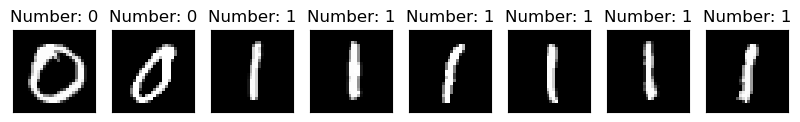

In [4]:
test_plot_data, test_plot_targets = next(iter(test_dataloader))

_, axes = plt.subplots(1, 8, figsize=(10, 3))
for i in range(8):
    axes[i].imshow(test_plot_data[i][0], cmap="gray", interpolation="none")
    axes[i].set_title(f"Number: {test_plot_targets[i]}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

## Create the Quantum Circuit for the Hybrid Model

The quantum circuit is defined in the `hybrid.isq` file. We use `tempfile`to simulate here

In [5]:
FILE_CONTENT = """\
import std;


param inputs[], weights[];
qbit q[2];

procedure single_h(qbit q[]) {
    for i in 0:q.length {
        H(q[i]);
    }
}

procedure adjacent_cz(qbit q[]) {
    for i in 0:q.length-1 {
        CZ(q[i], q[i+1]);
    }
}

procedure encode_inputs(qbit q[], int start_idx) {
    for i in 0:q.length {
        Rz(inputs[i+start_idx], q[i]);
    }
}

procedure encode_weights(qbit q[], int start_idx) {
    for i in 0:q.length {
        Rx(weights[i+start_idx], q[i]);
    }
    for i in 0:q.length {
        Ry(weights[i+start_idx+q.length], q[i]);
    }
    for i in 0:q.length {
        Rz(weights[i+start_idx+q.length*2], q[i]);
    }
}


procedure main() {

    single_h(q);
    encode_inputs(q, 0);
    adjacent_cz(q);

    encode_weights(q, 0);
    adjacent_cz(q);

    encode_weights(q, 6);
    adjacent_cz(q);

    M(q[0]);
    M(q[1]);
}"""

Create the quantum machine learning circuit using Python.

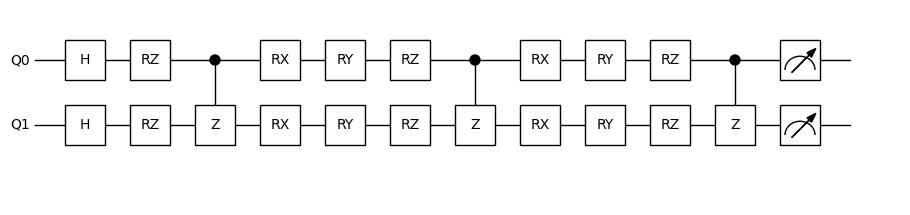

In [6]:
import tempfile
from pathlib import Path

from isqtools.draw import Drawer

backend = TorchBackend()
with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir_path = Path(temp_dir)
    temp_file_path = temp_dir_path / "hybrid.isq"
    with open(temp_file_path, "w") as temp_file:
        temp_file.write(FILE_CONTENT)

    qc = IsqCircuit(
        file=str(temp_file_path),
        backend=backend,
        sample=False,
    )


def circuit(inputs, weights):
    param = {
        "inputs": inputs,
        "weights": weights,
    }
    result = qc.measure(**param)
    return torch.cat((result[0].view(-1), result[2].view(-1)))


qnn = TorchLayer(
    circuit=circuit,
    num_weights=12,
    is_vmap=True,
)

dr = Drawer()
dr.plot(qc.qcis)

## Build the Classical-Quantum Hybrid Network

Since `qnn` inherits from `torch.nn.Module`, it can be easily integrated into a classical neural network to form a classical-quantum hybrid model.

Here, we use a convolutional neural network (CNN) followed by fully connected layers to process image data. The `qnn` is inserted into the fully connected part of the network, forming the hybrid architecture.

In this setup:

- The `inputs` to `qnn` have dimension 2.
- The `qnn` returns a measurement output of dimension 2.

Thus, `qnn` is placed between two linear layers that match this shape.

**Important**: Always ensure the input and output dimensions of `qnn` are compatible with the surrounding classical layers. Otherwise, the hybrid network cannot be constructed properly.

In [7]:
class HybridNet(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
            qnn,
            nn.Linear(2, 2),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [8]:
hybrid_net = HybridNet(qnn)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(hybrid_net.parameters(), lr=0.001)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

## Train the Neural Network

Train the classical-quantum hybrid neural network for 5 epochs. During training, use standard PyTorch procedures — including forward pass, loss computation, backpropagation, and parameter updates — to optimize both classical and quantum components.

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, hybrid_net, loss_fn, optimizer)
    test(test_dataloader, hybrid_net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.822773  [   10/  400]
loss: 0.584339  [  110/  400]
loss: 0.547312  [  210/  400]
loss: 0.492907  [  310/  400]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.493613 

Epoch 2
-------------------------------
loss: 0.521913  [   10/  400]
loss: 0.541909  [  110/  400]
loss: 0.444593  [  210/  400]
loss: 0.484125  [  310/  400]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.455073 

Epoch 3
-------------------------------
loss: 0.465106  [   10/  400]
loss: 0.478267  [  110/  400]
loss: 0.471614  [  210/  400]
loss: 0.465876  [  310/  400]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.427130 

Epoch 4
-------------------------------
loss: 0.424858  [   10/  400]
loss: 0.420086  [  110/  400]
loss: 0.431515  [  210/  400]
loss: 0.420472  [  310/  400]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.396076 

Epoch 5
-------------------------------
loss: 0.414942  [   10/  400]
loss: 0.384991  [  110/  400]
loss: 0.457078  [  210/  400]
loss: 0.377611  [  

## Model Validation

Evaluate the model’s prediction accuracy on the test dataset by comparing its predicted labels with the true labels. This provides a direct measure of the classification performance of the hybrid neural network.

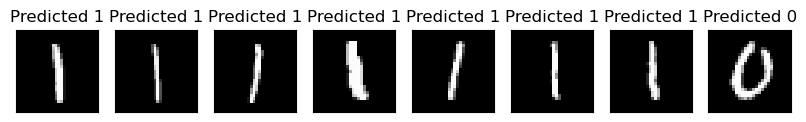

In [11]:
count = 0
_, axes = plt.subplots(1, 8, figsize=(10, 3))
hybrid_net.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_dataloader):
        if count == 8:
            break
        output = hybrid_net(data[0:1])
        pred = output.argmax(dim=1, keepdim=True)
        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray", interpolation="none")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title(f"Predicted {pred.item()}")
        count += 1

## Environment Information

The following versions of software and libraries are used in this tutorial:

In [12]:
import platform
import subprocess
from importlib.metadata import version

print(f"Python version used in this tutorial: {platform.python_version()}")
print(f"Execution environment: {platform.system()} {platform.release()}\n")


isqc_version = subprocess.check_output(
    ["isqc", "-V"], stderr=subprocess.STDOUT, text=True
).strip()
print(f"isqc version: {isqc_version}")

isqtools_version = version("isqtools")
print(f"isqtools version: {isqtools_version}")

numpy_version = version("numpy")
print(f"NumPy version: {isqtools_version}")

torch_version = version("torch")
print(f"Torch version: {torch_version}")

torchvision_version = version("torchvision")
print(f"torchvision version: {torchvision_version}")

Python version used in this tutorial: 3.13.5
Execution environment: Linux 6.12.41

isqc version: isQ Compiler 0.2.5
isqtools version: 1.3.0
NumPy version: 1.3.0
Torch version: 2.7.1
torchvision version: 0.22.1
